In [1]:
import numpy as np
from matplotlib import path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from funcs import calcular_IJ, calcular_streamline, xfoil

# Solución numérica

In [11]:
flagAirfoil = [
    0,  # Crear perfil NACA especificado en XFOIL
    1,  # Cargar perfil desde el directorio
]

Vinf = 1
alpha = 0
NACA = "0024"
alpha_rad = alpha * (np.pi / 180)

PPAR = [
    "170",  # "Number of panel nodes"
    "4",  # "Panel bunching paramter"
    "1",  # "TE/LE panel density ratios"
    "1",  # "Refined area/LE panel density ratio"
    "1 1",  # "Top side refined area x/c limits"
    "1 1",
]

In [ ]:
xFoilResults = xfoil(NACA, PPAR, alpha, flagAirfoil)
afName = xFoilResults[0]
xFoilX = xFoilResults[1]
xFoilY = xFoilResults[2]
xFoilCP = xFoilResults[3]
XB = xFoilResults[4]
YB = xFoilResults[5]
xFoilCL = xFoilResults[6]
xFoilCD = xFoilResults[7]
xFoilCM = xFoilResults[8]

num_pts = len(XB)
num_pan = num_pts - 1

edge = np.zeros(num_pan)
for i in range(num_pan):
    edge[i] = (XB[i + 1] - XB[i]) * (YB[i + 1] + YB[i])

sumEdge = np.sum(edge)

if sumEdge < 0:
    XB = np.flipud(XB)
    YB = np.flipud(YB)

XC = np.zeros(num_pan)
YC = np.zeros(num_pan)
S = np.zeros(num_pan)
phi = np.zeros(num_pan)

XC = 0.5 * (XB[:-1] + XB[1:])
YC = 0.5 * (YB[:-1] + YB[1:])
dx = XB[1:] - XB[:-1]
dy = YB[1:] - YB[:-1]
S = np.sqrt(dx**2 + dy**2)
phi = np.arctan2(dy, dx)
phi = np.where(phi < 0, phi + 2 * np.pi, phi)

phi = np.arctan2(dy, dx)

phi = np.where(phi < 0, phi + 2 * np.pi, phi)

delta = phi + (np.pi / 2)
beta = delta - alpha_rad
beta[beta > 2 * np.pi] = beta[beta > 2 * np.pi] - 2 * np.pi

In [ ]:
I, J = calcular_IJ(XC, YC, XB, YB, phi, S)

A = I + np.pi * np.eye(num_pan, num_pan)
b = -Vinf * 2 * np.pi * np.cos(beta)

lam = np.linalg.solve(A, b)
print("Sum of Lambda: ", round(sum(lam * S), 3))

Vt = np.zeros(num_pan)
Cp = np.zeros(num_pan)
for i in range(num_pan):
    addVal = 0
    for j in range(num_pan):
        addVal = addVal + (lam[j] / (2 * np.pi)) * J[i, j]

    Vt[i] = Vinf * np.sin(beta[i]) + addVal
    Cp[i] = 1 - (Vt[i] / Vinf) ** 2

CN = -Cp * S * np.sin(beta)
CA = -Cp * S * np.cos(beta)

CL = sum(CN * np.cos(alpha_rad)) - sum(CA * np.sin(alpha_rad))
CD = sum(CN * np.sin(alpha_rad)) + sum(CA * np.cos(alpha_rad))
CM = sum(Cp * (XC - 0.25) * S * np.cos(phi))

print("======= Resultados =======")
print("Coeficiente de sustentación (CL)")
print("\tSPM  : %2.8f" % CL)
print("\tXFOIL: %2.8f" % xFoilCL)
print("Coeficiente de arrastre (CD)")
print("\tSPM  : %2.8f" % CD)
print("\tXFOIL: %2.8f" % xFoilCD)
print("Coeficiente de momento (CM)")
print("\tSPM  : %2.8f" % CM)
print("\tXFOIL: %2.8f" % xFoilCM)


Sum of Lambda:  0.004
======= Resultados =======
Coeficiente de sustentación (CL)
	SPM  : 0.00000012
	XFOIL: -0.00000000
Coeficiente de arrastre (CD)
	SPM  : 0.00122673
	XFOIL: 0.00000000
Coeficiente de momento (CM)
	SPM  : 0.00000004
	XFOIL: 0.00000000


# Streamlines

In [ ]:
nGridX = 100
nGridY = 100
xVals = [-0.5, 1.5]
yVals = [-0.5, 0.5]

slPct = 40
Ysl = np.linspace(yVals[0], yVals[1], int((slPct / 100) * nGridY))
Xsl = xVals[0] * np.ones(len(Ysl))
XYsl = np.vstack((Xsl.T, Ysl.T)).T

Xgrid = np.linspace(xVals[0], xVals[1], nGridX)
Ygrid = np.linspace(yVals[0], yVals[1], nGridY)
XX, YY = np.meshgrid(Xgrid, Ygrid)

Vx = np.zeros([nGridX, nGridY])
Vy = np.zeros([nGridX, nGridY])

AF = np.vstack((XB.T, YB.T)).T
afPath = path.Path(AF)

for m in range(nGridX):
    for n in range(nGridY):
        XP = XX[m, n]
        YP = YY[m, n]
        Mx, My = calcular_streamline(XP, YP, XB, YB, phi, S)
        if afPath.contains_points([(XP, YP)]):
            Vx[m, n] = 0
            Vy[m, n] = 0
        else:
            Vx[m, n] = Vinf * np.cos(alpha_rad) + sum(lam * Mx / (2 * np.pi))
            Vy[m, n] = Vinf * np.sin(alpha_rad) + sum(lam * My / (2 * np.pi))

Vxy = np.sqrt(Vx**2 + Vy**2)
CpXY = 1 - (Vxy / Vinf) ** 2


# Gráficas

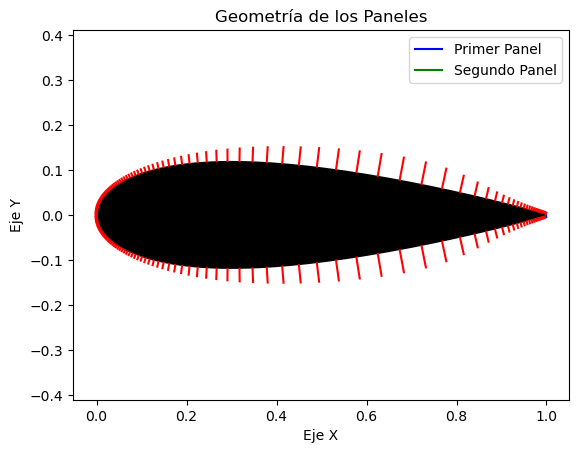

In [ ]:
# Geometría de los paneles
fig = plt.figure(1)
plt.cla()
plt.fill(XB, YB, 'k')
X = np.zeros(2)
Y = np.zeros(2)
for i in range(num_pan):
    X[0] = XC[i]
    X[1] = XC[i] + S[i] * np.cos(delta[i])
    Y[0] = YC[i]
    Y[1] = YC[i] + S[i] * np.sin(delta[i])
    if i == 0:
        plt.plot(X, Y, 'b-', label='Primer Panel')
    elif i == 1:
        plt.plot(X, Y, 'g-', label='Segundo Panel')
    else:
        plt.plot(X, Y, 'r-')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Geometría de los Paneles')
plt.axis('equal')
plt.legend()
plt.show()

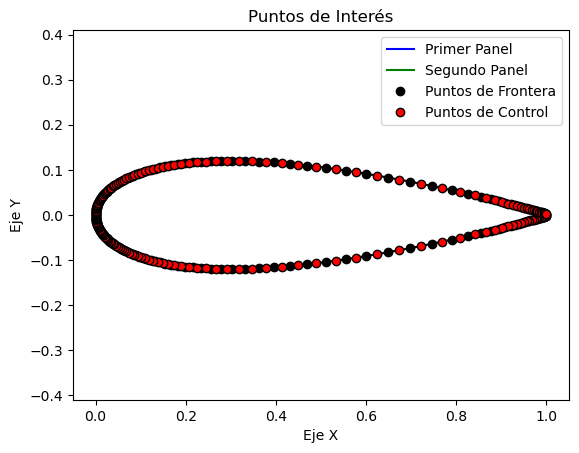

In [ ]:
# Puntos de interés
fig = plt.figure(2)
plt.cla()
plt.plot(XB, YB, "k-")
plt.plot([XB[0], XB[1]], [YB[0], YB[1]], "b-", label="Primer Panel")
plt.plot([XB[1], XB[2]], [YB[1], YB[2]], "g-", label="Segundo Panel")
plt.plot(XB, YB, "ko", markerfacecolor="k", label="Puntos de Frontera")
plt.plot(XC, YC, "ko", markerfacecolor="r", label="Puntos de Control")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.axis("equal")
plt.legend()
plt.title("Puntos de Interés")
plt.show()

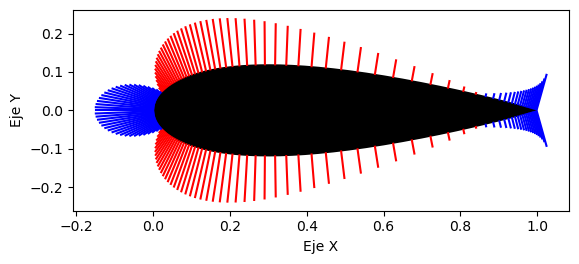

In [ ]:
# Vectores de Cp en cada panel
fig = plt.figure(3)
plt.cla()
Cps = np.absolute(Cp * 0.15)
X = np.zeros(2)
Y = np.zeros(2)
for i in range(len(Cps)):
    X[0] = XC[i]
    X[1] = XC[i] + Cps[i] * np.cos(delta[i])
    Y[0] = YC[i]
    Y[1] = YC[i] + Cps[i] * np.sin(delta[i])

    if Cp[i] < 0:
        plt.plot(X, Y, "r-")
    elif Cp[i] >= 0:
        plt.plot(X, Y, "b-")
plt.fill(XB, YB, "k")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.gca().set_aspect("equal")
plt.show()


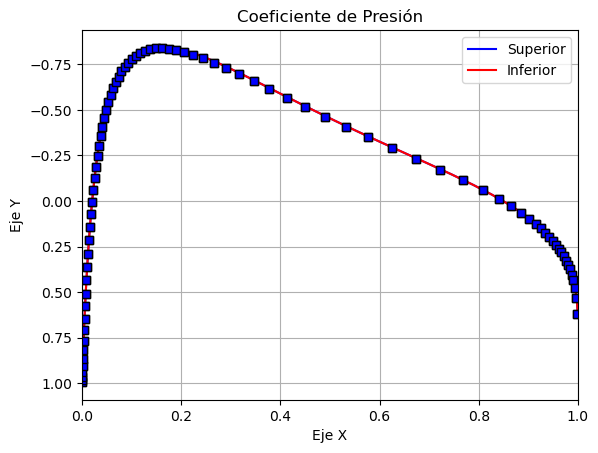

In [ ]:
# Coeficiente de presión
fig = plt.figure(4)
plt.cla()
midIndX = int(np.floor(len(xFoilCP) / 2))
midIndS = int(np.floor(len(Cp) / 2))
plt.plot(xFoilX[0:midIndX], xFoilCP[0:midIndX], 'b-', label='Superior')
plt.plot(xFoilX[midIndX + 1:len(xFoilX)], xFoilCP[midIndX + 1:len(xFoilX)], 'r-', label='Inferior')
plt.plot(XC[0:midIndS], Cp[0:midIndS], 'ks', markerfacecolor='r')
plt.plot(XC[midIndS + 1:len(XC)], Cp[midIndS + 1:len(XC)], 'ks', markerfacecolor='b')
plt.xlim(0, 1)
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Coeficiente de Presión')
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
plt.show()


FloatingPointError: underflow encountered in multiply

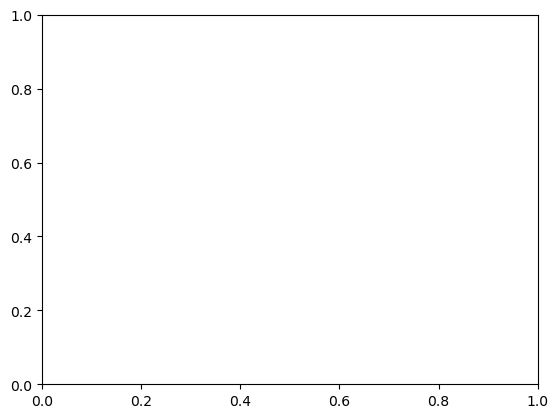

In [ ]:
# Líneas de flujo
fig = plt.figure(5)
plt.cla()
plt.streamplot(
    XX,
    YY,
    Vx,
    Vy,
    linewidth=0.5,
    density=10,
    color="b",
    arrowstyle="-",
    start_points=XYsl,
)
plt.fill(XB, YB, "k")
plt.title("Líneas de flujo")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.gca().set_aspect("equal")
plt.xlim(xVals)
plt.ylim(yVals)
plt.show()

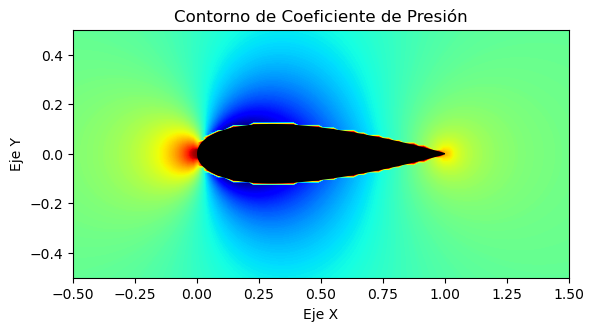

In [ ]:
# Contorno de Cp
fig = plt.figure(6)
plt.cla()
plt.contourf(XX, YY, CpXY, 500, cmap="jet")
plt.fill(XB, YB, "k")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.gca().set_aspect("equal")
plt.xlim(xVals)
plt.ylim(yVals)
plt.title("Contorno de Coeficiente de Presión")
plt.show()